### Tasks

#### figure out a way to make the model deeper 
#### consider small model as low rank representation and project higher. (using outer product) train only small number of outer product parameters - https://arxiv.org/pdf/2012.13255.pdf
#### study the difference between Llama 7B and 33B 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv("Data/YearPredictionMSD/YearPredictionMSD.txt", names = list(range(91)))

In [3]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515340,2006,51.28467,45.88068,22.19582,-5.53319,-3.61835,-16.36914,2.12652,5.18160,-8.66890,...,4.81440,-3.75991,-30.92584,26.33968,-5.03390,21.86037,-142.29410,3.42901,-41.14721,-15.46052
515341,2006,49.87870,37.93125,18.65987,-3.63581,-27.75665,-18.52988,7.76108,3.56109,-2.50351,...,32.38589,-32.75535,-61.05473,56.65182,15.29965,95.88193,-10.63242,12.96552,92.11633,10.88815
515342,2006,45.12852,12.65758,-38.72018,8.80882,-29.29985,-2.28706,-18.40424,-22.28726,-4.52429,...,-18.73598,-71.15954,-123.98443,121.26989,10.89629,34.62409,-248.61020,-6.07171,53.96319,-8.09364
515343,2006,44.16614,32.38368,-3.34971,-2.49165,-19.59278,-18.67098,8.78428,4.02039,-12.01230,...,67.16763,282.77624,-4.63677,144.00125,21.62652,-29.72432,71.47198,20.32240,14.83107,39.74909


In [4]:
class YearMSD(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

X_train, X_valid, y_train, y_valid = \
    train_test_split(dataset.loc[:, 1:], dataset.loc[:, 0], test_size=1/6, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

y_train_proc = y_train - min(min(y_train), min(y_valid))
y_valid_proc = y_valid - min(min(y_train), min(y_valid))

y_train = np.squeeze(np.eye(90)[y_train_proc.to_numpy().reshape(-1)])
y_valid = np.squeeze(np.eye(90)[y_valid_proc.to_numpy().reshape(-1)])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

print('X train shape : ', X_train.shape)
print('y train label shape : ', y_train.shape)
print('X valid  shape : ', X_valid.shape)
print('y valid shape: ', y_valid.shape)

X train shape :  (429454, 90)
y train label shape :  (429454, 90)
X valid  shape :  (85891, 90)
y valid shape:  (85891, 90)


In [6]:
train_dataset = YearMSD(X=torch.tensor(X_train, dtype=torch.float), y=torch.tensor(y_train, dtype=torch.float))
val_dataset = YearMSD(X=torch.tensor(X_valid, dtype=torch.float), y=torch.tensor(y_valid, dtype=torch.float))

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [7]:
dataiter = iter(train_loader)
X, y = next(dataiter)

print('X train shape on PyTorch : ', X.size())
print('y train shape on PyTorch : ', y.size())

X train shape on PyTorch :  torch.Size([128, 90])
y train shape on PyTorch :  torch.Size([128, 90])


In [9]:
from livelossplot import PlotLosses
from collections import defaultdict
device = torch.device("cuda")

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                cost_function, 
                optimizer,
                scheduler,
                train_loader,
                val_loader,
                name):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()
  recordlogs = defaultdict(list)

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
    logs = {}

    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in training mode.
    model.train()

    # Sample a batch on each iteration.
    for (batch_id, (xb, yb)) in enumerate(train_loader):
      model.zero_grad()
      # Move (x,y) data to GPU (if so desired).
      xb = xb.to(device)
      yb = yb.to(device)

      # Compute predictions.
      #print("debug", xb.shape, yb.shape)#, predicted.shape)
      predicted = model(xb)
      
      # Compute loss.
      loss = cost_function(predicted, yb)
      cumulative_loss += loss.item()

      # Compute gradients (autograd).
      loss.backward()
    
      # Count how many correct in batch.
      predicted_ = predicted.detach().sigmoid()
      _, x_max_ids = predicted_.max(dim = 1)
      _, y_max_ids = yb.max(dim = 1)
      correct += (x_max_ids == y_max_ids).sum().cpu().item()
      n_samples += xb.size(0)

      # Run one basic training step of SGD.
      optimizer.step()
      # This does basically the following operation.
      # for param in model.parameters():
      #    param.data -= learningRate * param.grad.data

      # Keep track of loss and accuracy for the plot.
      n_batches = 1 + batch_id 
      logs['loss'] = cumulative_loss / n_batches
      logs['accuracy'] = correct / n_samples
    
    # initialize control variables.
    correct = 0
    cumulative_loss = 0
    n_samples = 0

    # Set the model in evaluation mode.
    model.eval()

    # No need to keep track of gradients for this part.
    with torch.no_grad():
      # Run the model on the validation set to keep track of accuracy there.
      for (batch_id, (xb, yb)) in enumerate(val_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)
    
        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb)
        cumulative_loss += loss.item()
        
        # Count how many correct in batch.
        predicted_ = predicted.detach().sigmoid()
        _, x_max_ids = predicted_.max(dim = 1)
        _, y_max_ids = yb.max(dim = 1)
        correct += (x_max_ids == y_max_ids).sum().cpu().item()
        n_samples += xb.size(0)

        # Keep track of loss and accuracy for the plot.
        n_batches = 1 + batch_id
        logs['val_loss'] = cumulative_loss / n_batches
        logs['val_accuracy'] = correct / n_samples

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'checkpoints/best_model_so_far_' + name + '.pth')

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()
    
    recordlogs['loss'].append(logs['loss'])
    recordlogs['val_loss'].append(logs['loss'])
    recordlogs['accuracy'].append(logs['accuracy'])
    recordlogs['val_accuracy'].append(logs['val_accuracy'])

    # What is this for? Please look it up.
    if scheduler != -1:
        scheduler.step()
        
  return recordlogs
  # Load the model parameters for the one that achieved the best val accuracy.
  # model.load_state_dict(torch.load('best_model_so_far.pth'))    

### Check the performance of small-sized model

In [10]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(90, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 90)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [11]:
learningRate = 1e-4
modelSmall = MLPSmall()
optimizer = torch.optim.Adam(modelSmall.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelSmall)

MLPSmall(
  (layers): Sequential(
    (0): Linear(in_features=90, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=90, bias=True)
  )
)


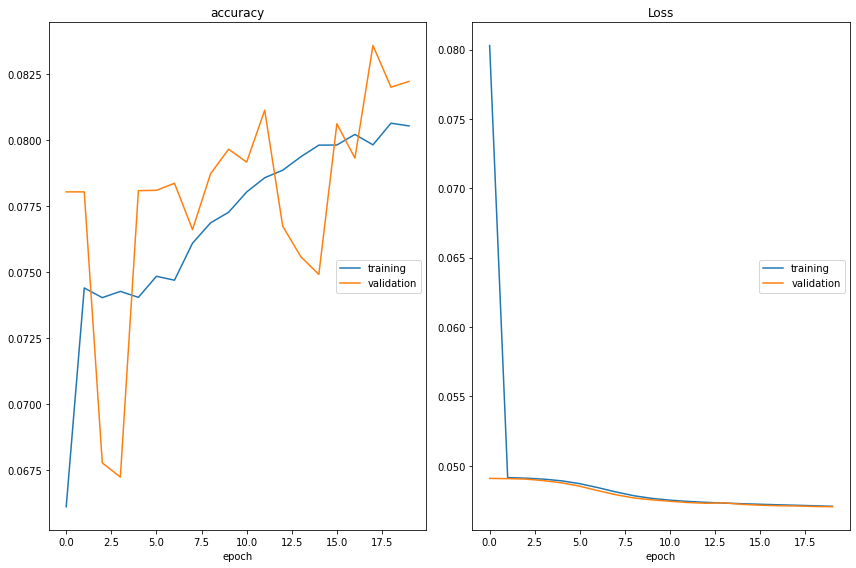

accuracy
	training         	 (min:    0.066, max:    0.081, cur:    0.081)
	validation       	 (min:    0.067, max:    0.084, cur:    0.082)
Loss
	training         	 (min:    0.047, max:    0.080, cur:    0.047)
	validation       	 (min:    0.047, max:    0.049, cur:    0.047)


In [12]:
small_logs = train_model(batch_size, n_epochs, learningRate, 
            modelSmall, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'small-MSD');

### Check the performance of medium-sized model

In [13]:
class MLPMedium(nn.Module):
    def __init__(self):
        super(MLPMedium, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(90, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 90)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [14]:
learningRate = 1e-4
modelMedium = MLPMedium()
optimizer = torch.optim.Adam(modelMedium.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(modelMedium)

MLPMedium(
  (layers): Sequential(
    (0): Linear(in_features=90, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=90, bias=True)
  )
)


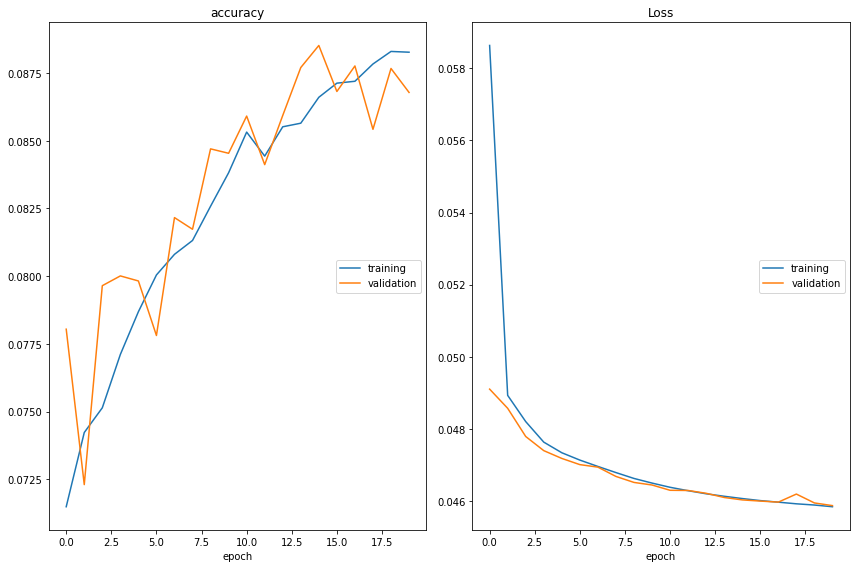

accuracy
	training         	 (min:    0.071, max:    0.088, cur:    0.088)
	validation       	 (min:    0.072, max:    0.089, cur:    0.087)
Loss
	training         	 (min:    0.046, max:    0.059, cur:    0.046)
	validation       	 (min:    0.046, max:    0.049, cur:    0.046)


In [15]:
medium_logs = train_model(batch_size, n_epochs, learningRate, 
            modelMedium, cost_function, optimizer, -1, 
            train_loader, val_loader, name = 'medium-MSD');

### Densify small model to the same parameters as the medium model

In [16]:
from scipy.stats import ortho_group
class MLPSmalltoMedium(nn.Module):
    def __init__(self, modelSmall):
        super(MLPSmalltoMedium, self).__init__()
        # extract weights from modelSmall
        self.layers = nn.Sequential(
            nn.Linear(90, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 90)
        )
        
        for layer in range(len(modelSmall.layers)):
            try:
                tempWeight =  modelSmall.layers[layer].weight.data
                if layer != len(modelSmall.layers) - 1:
                    left = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].out_features), np.s_[modelSmall.layers[layer].out_features:], 1), device=device, dtype=torch.float32)
#                     print("left: " + str(left.size()), "current: " + str(tempWeight.size()))
                    tempWeight = torch.matmul(left, tempWeight)
                if layer != 0:
                    right = torch.tensor(np.delete(ortho_group.rvs(self.layers[layer].in_features), np.s_[modelSmall.layers[layer].in_features:], 1), device=device, dtype=torch.float32)
#                     print("current: " + str(tempWeight.size()), "right: " + str(right.T.size()))
                    tempWeight = torch.matmul(tempWeight, right.T)
                
                self.layers[layer].weight.data = tempWeight
                
            
            except Exception as e:
                print("Layer " + str(layer) + ": " + str(e))
                
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [17]:
bestSmallModel = MLPSmall()
bestSmallModel.load_state_dict(torch.load('checkpoints/best_model_so_far_small-MSD.pth'))
bestSmallModel = bestSmallModel.to(device)
upscaledModel = MLPSmalltoMedium(bestSmallModel)

Layer 1: 'ReLU' object has no attribute 'weight'
Layer 3: 'ReLU' object has no attribute 'weight'


In [18]:
learningRate = 1e-4
optimizer = torch.optim.Adam(upscaledModel.parameters(), lr=learningRate)
cost_function = nn.BCEWithLogitsLoss()
batch_size = 128
n_epochs = 20
print(upscaledModel)

MLPSmalltoMedium(
  (layers): Sequential(
    (0): Linear(in_features=90, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=90, bias=True)
  )
)


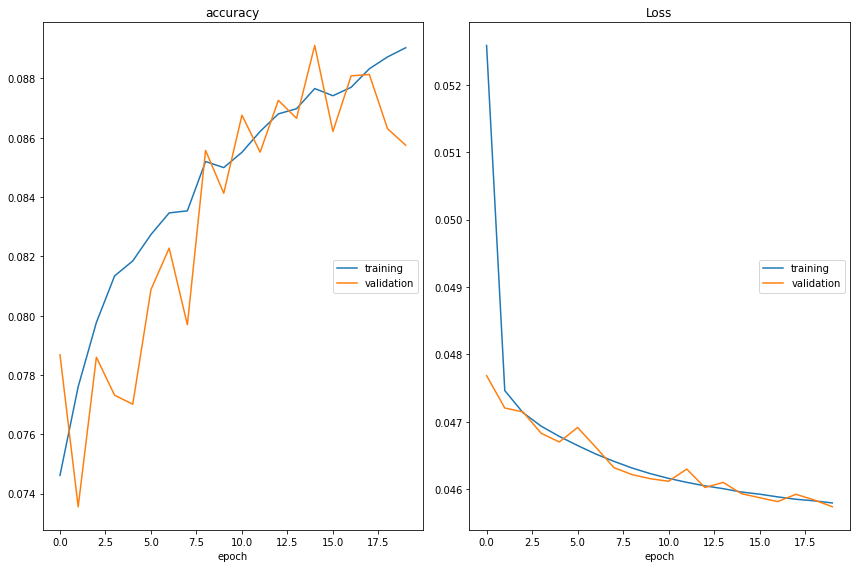

accuracy
	training         	 (min:    0.075, max:    0.089, cur:    0.089)
	validation       	 (min:    0.074, max:    0.089, cur:    0.086)
Loss
	training         	 (min:    0.046, max:    0.053, cur:    0.046)
	validation       	 (min:    0.046, max:    0.048, cur:    0.046)


In [19]:
upscaled_logs = train_model(batch_size, n_epochs, learningRate, 
            upscaledModel, cost_function, optimizer, -1, 
            train_loader, val_loader, name = "upscaled-MSD");

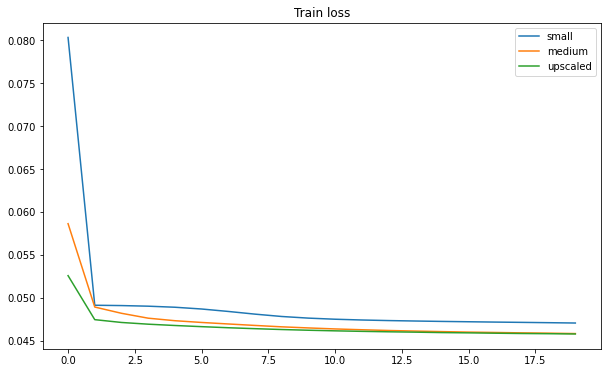

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['loss'])
plt.plot(medium_logs['loss'])
plt.plot(upscaled_logs['loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train loss")

plt.show()

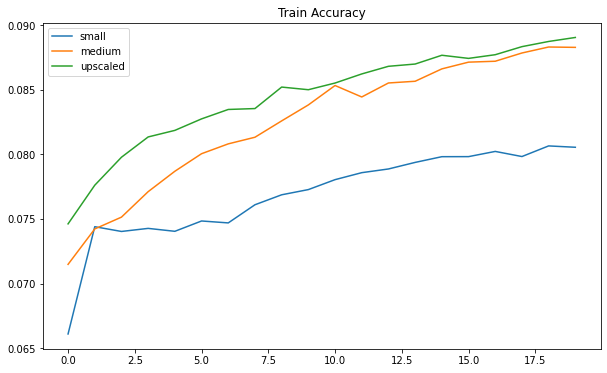

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['accuracy'])
plt.plot(medium_logs['accuracy'])
plt.plot(upscaled_logs['accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Train Accuracy")
plt.show()

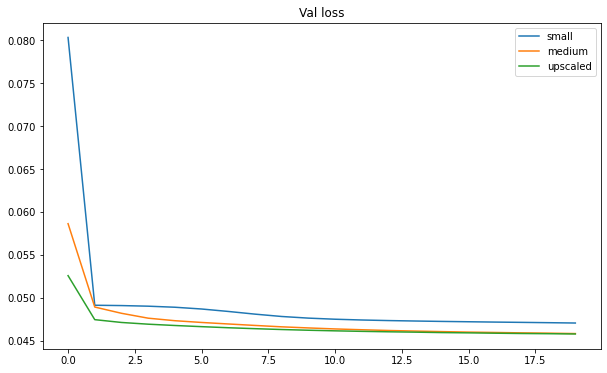

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_loss'])
plt.plot(medium_logs['val_loss'])
plt.plot(upscaled_logs['val_loss'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val loss")

plt.show()

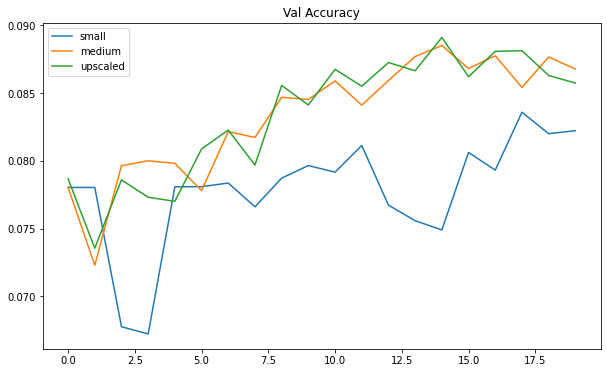

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(small_logs['val_accuracy'])
plt.plot(medium_logs['val_accuracy'])
plt.plot(upscaled_logs['val_accuracy'])

plt.legend(['small', 'medium','upscaled'])
plt.title("Val Accuracy")
plt.show()